This notebook is an adaptation from Lisa Alazraki's notebook used for training the previous version of the chatbot (https://www.doc.ic.ac.uk/~ae/papers/Lisa_Alazraki_report.pdf).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Dataset and data analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
_CITATION = """\
@inproceedings{rashkin2019towards,
  title = {Towards Empathetic Open-domain Conversation Models: a New Benchmark and Dataset},
  author = {Hannah Rashkin and Eric Michael Smith and Margaret Li and Y-Lan Boureau},
  booktitle = {ACL},
  year = {2019},
}
"""

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_train_equal.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_test_equal.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_val_equal.txt"

## T5 fine-tuning on the Emotion dataset


In [ ]:
%%capture
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:transformers.file_utils:PyTorch version 1.11.0+cu113 available.
INFO:transformers.file_utils:TensorFlow version 2.8.2 available.


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
label2int = {
  "sadness": 1,
  "joy": 2,
  "anger": 3,
  "fear": 4,
  "love": 5,
  "instability": 6,
  "disgust": 7,
  "disappointment": 8,
  "shame": 9,
  "guilt": 10,
  "envy": 11
}

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_emp_dia_train_equal", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_emp_dia_val_equal", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      #Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      #Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", #path for data files
    output_dir="", #path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False,
    opt_level='O1', 
    max_grad_norm=1.0,
    seed=42,
)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmph9sgwozz


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
#try out the tokenizer
text = "I am sad and feel like I have no energy today."
enc = tokenizer.encode_plus(text)
print(enc)

{'input_ids': [27, 183, 6819, 11, 473, 114, 27, 43, 150, 827, 469, 5], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
#check how it encodes the labels (they're all single ids)
emotions = [ "sadness", "joy", "anger", "fear", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy"]
for em in emotions:
  print(tokenizer.encode(em))

[24784]
[3922]
[11213]
[2971]
[333]
[29440]
[27635]
[19142]
[12447]
[20595]
[30312]


In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  #might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  #might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       #tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       #tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
#sanity check, val length should be 2000
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Emotion', 'my_emp_dia_val_equal', 512)
len(dataset)

781

In [ ]:
#view one sample
data = dataset[77]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

I was in a back room and heard a noise everyone else was in bed so I thought maybe someone was in the house.
fear


### Train

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/Individual Project/Data/Emotion/', 'output_dir': '/content/', 'num_train_epochs':6})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/Individual Project/Data/Emotion/', 'output_dir': '/content/', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 6, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /content/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
model = T5FineTuner(args)

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpjfn1tspo


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json in cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id"

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/t5-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/t5-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
INFO:transformers.tokenization_utils:loading

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.8819, device='cuda:0')

INFO:__main__:loss = tensor(0.8234, device='cuda:0')

INFO:__main__:train_loss = tensor(0.8234, device='cuda:0')

INFO:__main__:val_loss = tensor(0.8819, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(3.9025, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.5454, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.7748, device='cuda:0')

INFO:__main__:train_loss = tensor(0.7748, device='cuda:0')

INFO:__main__:val_loss = tensor(0.5454, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.7369, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4758, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(0.5809, device='cuda:0')

INFO:__main__:train_loss = tensor(0.5809, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4758, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.5448, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4550, device='cuda:0')

INFO:__main__:epoch = 2

INFO:__main__:loss = tensor(0.4677, device='cuda:0')

INFO:__main__:train_loss = tensor(0.4677, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4550, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.4839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4465, device='cuda:0')

INFO:__main__:epoch = 3

INFO:__main__:loss = tensor(0.3920, device='cuda:0')

INFO:__main__:train_loss = tensor(0.3920, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4465, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.4383, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4428, device='cuda:0')

INFO:__main__:epoch = 4

INFO:__main__:loss = tensor(0.2586, device='cuda:0')

INFO:__main__:train_loss = tensor(0.2586, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4428, device='cuda:0')



1

In [ ]:
torch.save(model.state_dict(), '/content/T5emotion_finetuned_emp_dia.pt')

In [ ]:
device = torch.device('cuda:0')

In [ ]:
model = T5FineTuner(args)
model.load_state_dict(torch.load('/content/T5emotion_finetuned_emp_dia.pt'))
model.to(device)


INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

T5FineTuner(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseReluDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_featur

## Evaluate on the test set

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Emotion/', 'my_emp_dia_test_equal', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print out some predictions
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: I felt so much love and affection when my son was moving to college. It was hard_comma_ as I
wasn't ready_comma_ but was so proud of him!

Actual sentiment: love
predicted sentiment: love

text: I fell down at work_comma_ and my khaki pants ripped open.

Actual sentiment: shame
predicted sentiment: shame

text: A customer is refusing to pay a bill because they claim it has already been paid but cannot
provide any proof of doing so.

Actual sentiment: anger
predicted sentiment: anger

text: I felt betrayed when my girlfriend kissed another guy at a party. She was drunk_comma_ true.
But still.

Actual sentiment: disappointment
predicted sentiment: guilt

text: My husband had to cancel a vacation for next month. It's because his other night manager is
terriblke and they cant afford to let him go.

Actual sentiment: disappointment
predicted sentiment: anger

text: When my dog died.

Actual sentiment: sadness
predicted sentiment: sadness

text: I felt heartbroken when my dog passed aw

#### Test Metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Emotion/', 'my_emp_dia_val_equal', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')
    #deal with invalid predictions if any:
    del outputs[i]
    del targets[i]

572 detected invalid prediction
677 detected invalid prediction


In [ ]:
print(metrics.classification_report(targets, outputs, digits=4))

                precision    recall  f1-score   support

         anger     0.6582    0.7324    0.6933        71
disappointment     0.5833    0.5915    0.5874        71
       disgust     0.7703    0.8028    0.7862        71
          envy     0.8000    0.7887    0.7943        71
          fear     0.5823    0.6479    0.6133        71
         guilt     0.6623    0.7183    0.6892        71
   instability     0.6197    0.6197    0.6197        71
           joy     0.8429    0.8429    0.8429        70
          love     0.8548    0.7571    0.8030        70
       sadness     0.6857    0.6761    0.6809        71
         shame     0.6727    0.5211    0.5873        71

      accuracy                         0.6996       779
     macro avg     0.7029    0.6999    0.6998       779
  weighted avg     0.7026    0.6996    0.6995       779



Now lets plot  the confusion matrix and see for which classes our model is getting confused

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

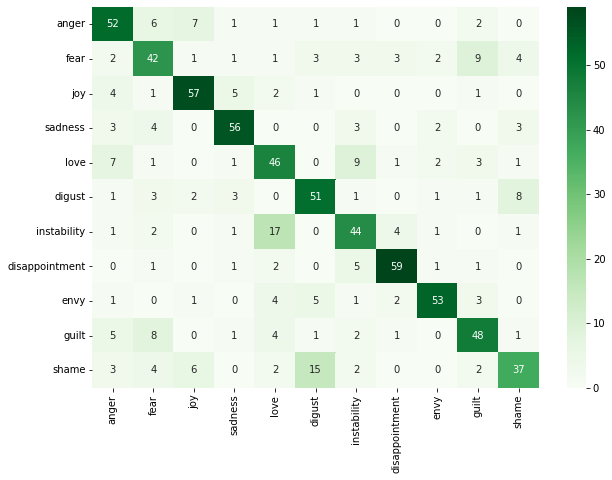

In [ ]:
df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "sadness", "love", "digust", "instability", "disappointment", "envy", "guilt", "shame"], columns = ["anger", "fear", "joy", "sadness", "love", "digust", "instability", "disappointment", "envy", "guilt", "shame"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

#Further finetune T5 model on Crowd-Sourced Data

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_train_equal_no_jealous.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_test_equal_no_jealous.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_val_equal_no_jealous.txt"

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="bt_train_equal_no_jealous", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="bt_val_equal_no_jealous", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

#Train model on our dataset

In [ ]:
#load tokenizer for our model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Emotion/', 'bt_val_equal_no_jealous', 512)

In [ ]:
#clear cache before training
torch.cuda.empty_cache()

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-3,
    weight_decay=0.0,
    adam_epsilon=1e-3,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=6,
    gradient_accumulation_steps=16, 
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0,
    seed=42,
)

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/Individual Project/Data/Emotion', 'output_dir': '/content/', 'num_train_epochs':6})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/Individual Project/Data/Emotion', 'output_dir': '/content/', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.001, 'weight_decay': 0.0, 'adam_epsilon': 0.001, 'warmup_steps': 0, 'train_batch_size': 1, 'eval_batch_size': 1, 'num_train_epochs': 6, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /content/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
#create instance of model and load previously finetuned weights
model = T5FineTuner(args)
model.load_state_dict(torch.load('/content/T5emotion_finetuned_emp_dia.pt'))

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

<All keys matched successfully>

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#training loop
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.5204, device='cuda:0')

INFO:__main__:loss = tensor(2.2173, device='cuda:0')

INFO:__main__:train_loss = tensor(2.2173, device='cuda:0')

INFO:__main__:val_loss = tensor(0.5204, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.6247, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4244, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.2506, device='cuda:0')

INFO:__main__:train_loss = tensor(2.2506, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4244, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.4720, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3811, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(0.0393, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0393, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3811, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.3562, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3805, device='cuda:0')

INFO:__main__:epoch = 2

INFO:__main__:loss = tensor(0.1841, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1841, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3805, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.2969, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3370, device='cuda:0')

INFO:__main__:epoch = 3

INFO:__main__:loss = tensor(0.7386, device='cuda:0')

INFO:__main__:train_loss = tensor(0.7386, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3370, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.2598, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3450, device='cuda:0')

INFO:__main__:epoch = 4

INFO:__main__:loss = tensor(2.4019, device='cuda:0')

INFO:__main__:train_loss = tensor(2.4019, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3450, device='cuda:0')



1

In [ ]:
torch.save(model.state_dict(), '/content/T5emotion_twicefinetuned.pt')

In [ ]:
device = torch.device('cuda:0')

In [ ]:
model = T5FineTuner(args)
model.load_state_dict(torch.load('/content/T5emotion_twicefinetuned.pt'))
model.to(device)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

T5FineTuner(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseReluDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_featur

##Test set eval

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Emotion/', 'bt_test_equal_no_jealous', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print some predictions to view
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: i just dont want to go on anymore everything seems so hopeless

Actual sentiment: sadness
predicted sentiment: sadness

text: i dropped out of university today because i dont feel i belong there

Actual sentiment: instability
predicted sentiment: instability

text: upset as i have been overspending and am in debt

Actual sentiment: shame
predicted sentiment: anger

text: im afraid that my dog wont make it through surgery

Actual sentiment: fear
predicted sentiment: fear

text: sometimes i dont like me job because of my supervisor

Actual sentiment: instability
predicted sentiment: instability

text: i dont feel like going to work today i dont like the working atmosphere

Actual sentiment: instability
predicted sentiment: instability

text: i am a little upset and depressed this afternoon

Actual sentiment: sadness
predicted sentiment: sadness

text: i am feeling nervous

Actual sentiment: fear
predicted sentiment: fear

text: my girlfriend is pretty and petite i am chubby and no 

In [ ]:
#predict whole test set
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Emotion/', 'bt_test_equal_no_jealous', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')
    #deal with invalid predictions if any:
    del outputs[i]
    del targets[i]

In [ ]:
#other metrics
print(metrics.classification_report(targets, outputs, digits=4))

                precision    recall  f1-score   support

         anger     0.7727    0.8095    0.7907        21
disappointment     0.8438    0.8710    0.8571        31
       disgust     0.8333    0.8333    0.8333        24
          envy     0.9310    1.0000    0.9643        27
          fear     0.9231    0.9231    0.9231        26
         guilt     0.7391    0.9444    0.8293        18
   instability     0.7778    0.8077    0.7925        26
           joy     0.9524    0.9524    0.9524        21
          love     0.9583    0.9200    0.9388        25
       sadness     0.7895    0.6818    0.7317        22
         shame     1.0000    0.7273    0.8421        22

      accuracy                         0.8631       263
     macro avg     0.8655    0.8610    0.8596       263
  weighted avg     0.8683    0.8631    0.8625       263



####Confusion matrix

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

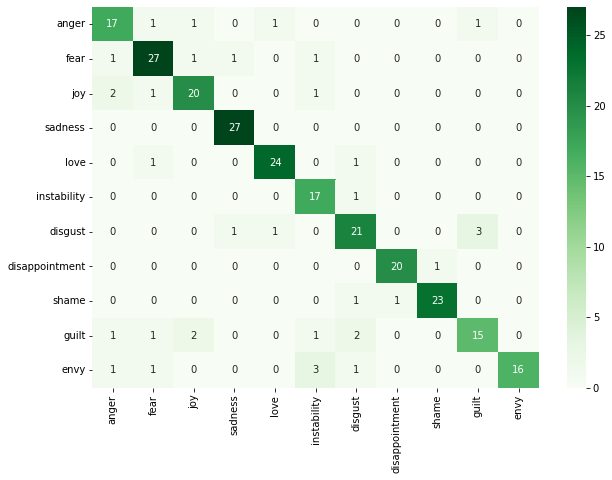

In [ ]:
df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "sadness", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy"], columns = ["anger", "fear", "joy", "sadness", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')